## SKA ALGORITHM

Step: 1, Total Steps: 1, Entropy: 0.0000
Step: 2, Total Steps: 2, Entropy: -0.0290
Step: 3, Total Steps: 3, Entropy: -0.0310
Step: 4, Total Steps: 4, Entropy: -0.0324
Step: 5, Total Steps: 5, Entropy: -0.0338
Step: 6, Total Steps: 6, Entropy: -0.0353
Step: 7, Total Steps: 7, Entropy: -0.0369
Step: 8, Total Steps: 8, Entropy: -0.0386
Step: 9, Total Steps: 9, Entropy: -0.0404
Step: 10, Total Steps: 10, Entropy: -0.0422
Step: 11, Total Steps: 11, Entropy: -0.0442
Step: 12, Total Steps: 12, Entropy: -0.0462
Step: 13, Total Steps: 13, Entropy: -0.0483
Step: 14, Total Steps: 14, Entropy: -0.0505
Step: 15, Total Steps: 15, Entropy: -0.0529
Step: 16, Total Steps: 16, Entropy: -0.0553
Step: 17, Total Steps: 17, Entropy: -0.0579
Step: 18, Total Steps: 18, Entropy: -0.0605
Step: 19, Total Steps: 19, Entropy: -0.0634
Step: 20, Total Steps: 20, Entropy: -0.0663
Step: 21, Total Steps: 21, Entropy: -0.0694
Step: 22, Total Steps: 22, Entropy: -0.0726
Step: 23, Total Steps: 23, Entropy: -0.0760
Step: 2

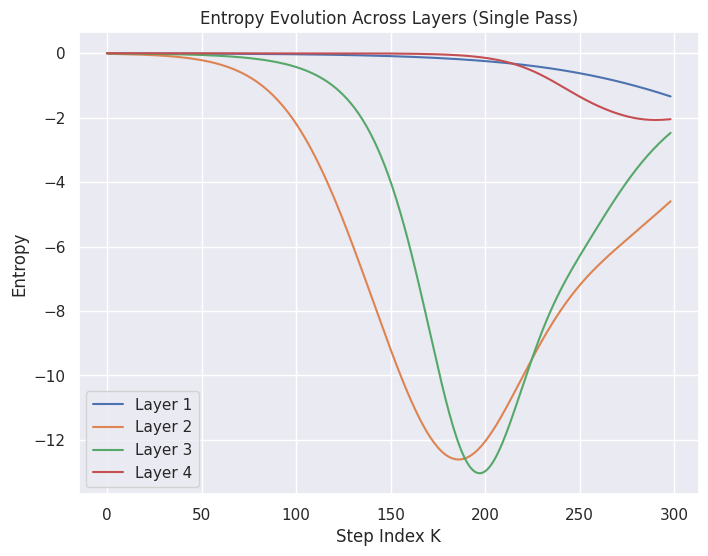

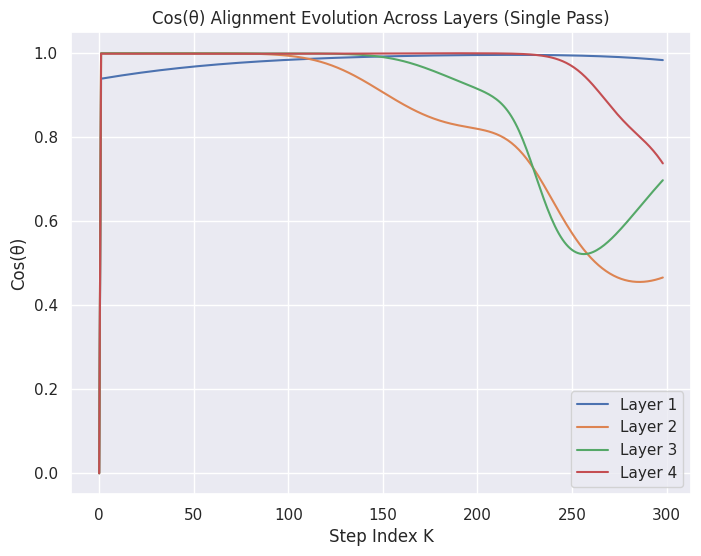

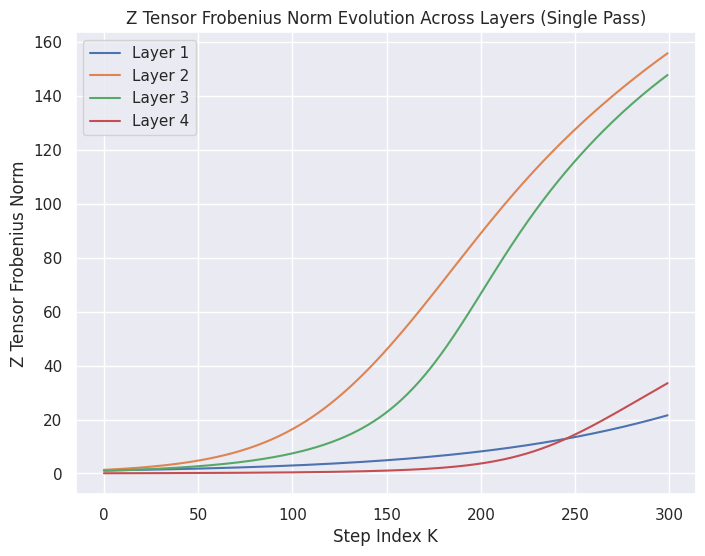

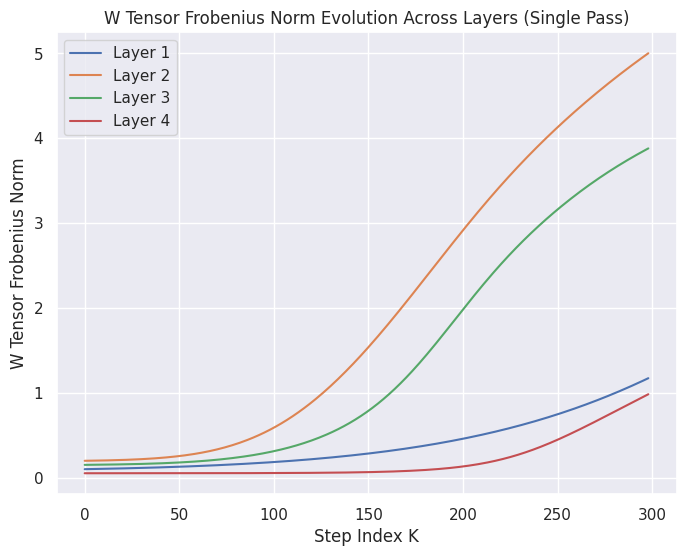

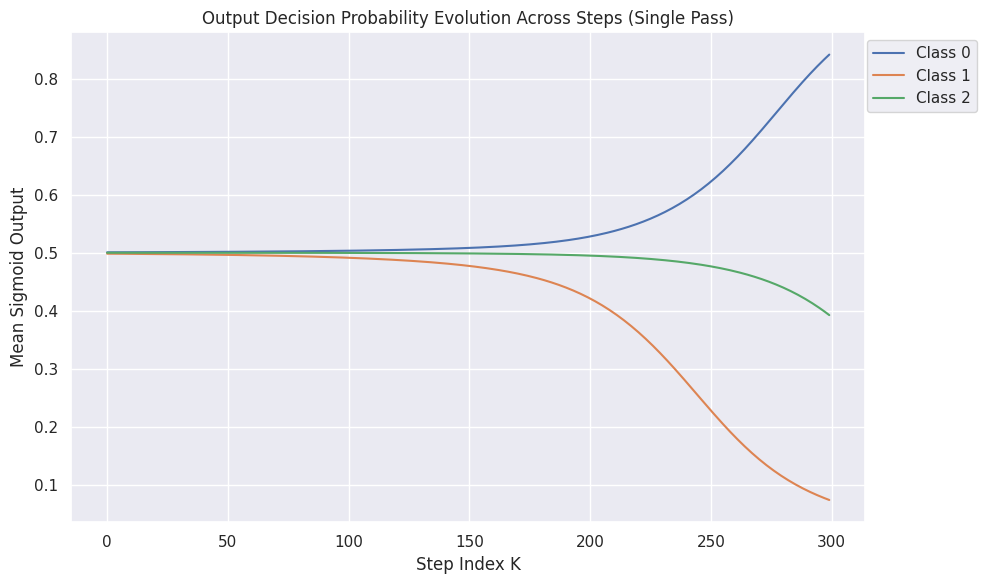

Training complete. Visualizations generated.
Avg Entropy=-10.3667, Steps=299, Time=2.52s


In [1]:
# Import Libraries
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load Iris dataset
iris = datasets.load_iris()

# X and y
X = iris.data
y = iris.target

# Splitting the dataset into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Min-Max Scaling (0 to 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting Numpy arrays to Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# SKA Class
class SKAModel(nn.Module):

  def __init__(self, input_size, layer_sizes=[24, 18, 12, 3], K=50):

    """
    SKA model: Knowledge Accumulation and Entropy Minimization-based Learning.

    Args:
        input_size (int): Number of input neurons.
        layer_sizes (list): List of neurons per layer.
        K (int): Number of forward passes.
    """

    super().__init__()
    self.input_size = input_size
    self.layer_sizes = layer_sizes
    self.K = K  # Number of forward learning steps

    # Initialize weights and biases as trainable tensors
    self.weights = nn.ParameterList()
    self.biases = nn.ParameterList()
    prev_size = input_size

    for size in layer_sizes:
      self.weights.append(nn.Parameter(torch.randn(prev_size, size) * 0.01))
      self.biases.append(nn.Parameter(torch.zeros(size)))
      prev_size = size

    # Knowledge, decision, entropy, and history tracking tensors
    self.Z = [None] * len(layer_sizes)  # Knowledge tensors
    self.D = [None] * len(layer_sizes)  # Decision probabilities
    self.D_prev = [None] * len(layer_sizes)  # Previous decision probabilities
    self.delta_D = [None] * len(layer_sizes)  # Decision shifts
    self.entropy = [None] * len(layer_sizes)  # Layer-wise entropy

    # History tracking for visualization
    self.entropy_history = [[] for _ in range(len(layer_sizes))]
    self.cosine_history = [[] for _ in range(len(layer_sizes))]
    self.output_history = []  # Stores decision probabilities over steps

    # Store Frobenius norms for each layer per forward step
    self.frobenius_history = [[] for _ in range(len(layer_sizes))]

    # Store Frobenius norms for each layer's weight matrix W per forward step
    self.weight_frobenius_history = [[] for _ in range(len(layer_sizes))]

  def forward(self, x):
    """Forward pass through SKA model."""

    for l in range(len(self.layer_sizes)):

      # Compute structured knowledge tensor Z = Wx + b
      z = torch.mm(x, self.weights[l]) + self.biases[l]

      # Compute and store Frobenius norm of z
      frobenius_norm = torch.norm(z, p='fro')
      self.frobenius_history[l].append(frobenius_norm.item())

      # Sigmoid Activation
      d = torch.sigmoid(z)

      # Store knowledge and decision probabilities
      self.Z[l] = z
      self.D[l] = d

      x = d  # Feed decision probabilities to the next layer

    return x

  def calculate_entropy(self):
    """Computes entropy minimization across layers."""
    total_entropy = 0

    for l in range(len(self.layer_sizes)):
      if self.Z[l] is not None and self.D_prev[l] is not None and self.D[l] is not None:

        # Compute decision shifts
        self.delta_D[l] = self.D[l] - self.D_prev[l]

        # Compute entropy using the SKA formula
        dot_product = torch.sum(self.Z[l] * self.delta_D[l])
        layer_entropy = -1 / np.log(2) * dot_product
        self.entropy[l] = layer_entropy.item()
        self.entropy_history[l].append(layer_entropy.item())

        # Compute alignment metric (cosine similarity)
        z_norm = torch.norm(self.Z[l])
        delta_d_norm = torch.norm(self.delta_D[l])

        if z_norm > 0 and delta_d_norm > 0:
          cos_theta = dot_product / (z_norm * delta_d_norm)
          self.cosine_history[l].append(cos_theta.item())
        else:
          self.cosine_history[l].append(0.0)  # Default if norms are zero

        total_entropy += layer_entropy
    return total_entropy

    return total_entropy

  def ska_update(self, inputs, learning_rate=0.01):

    """Weight update using entropy minimization (no backpropagation)."""

    for l in range(len(self.layer_sizes)):
      if self.delta_D[l] is not None:

        # Previous layer's output
        prev_output = inputs.view(inputs.shape[0], -1) if l == 0 else self.D_prev[l-1]

        # Compute sigmoid derivative: D * (1 - D)
        d_prime = self.D[l] * (1 - self.D[l])  # Sigmoid derivative

        # Compute entropy gradient
        gradient = -1 / np.log(2) * (self.Z[l] * d_prime + self.delta_D[l])

        # Compute weight updates via outer product
        dW = torch.matmul(prev_output.t(), gradient) / prev_output.shape[0]

        # Update weights and biases
        self.weights[l] = self.weights[l] - learning_rate * dW
        self.biases[l] = self.biases[l] - learning_rate * gradient.mean(dim=0)

  def initialize_tensors(self):

    """Resets knowledge and decision tensors at the start of each training iteration."""

    for l in range(len(self.layer_sizes)):
      self.Z[l], self.D[l], self.D_prev[l], self.delta_D[l], self.entropy[l] = None, None, None, None, None
      self.entropy_history[l] = []
      self.cosine_history[l] = []

    self.output_history = []  # Reset output history

    # Reset Frobenius norm history
    self.frobenius_history = [[] for _ in range(len(self.layer_sizes))]

    # Reset weight Frobenius norm history
    self.weight_frobenius_history = [[] for _ in range(len(self.layer_sizes))]

  def visualize_entropy_heatmap(self, step):
    """Dynamically scales the heatmap range and visualizes entropy reduction."""
    entropy_data = np.array(self.entropy_history)
    vmin = np.min(entropy_data)  # Dynamically set minimum entropy value
    vmax = 0.0  # Keep 0 as the upper limit for standardization
    plt.figure(figsize=(12, 8))
    sns.heatmap(entropy_data, cmap="Blues_r", vmin=vmin, vmax=vmax,
                xticklabels=range(1, entropy_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])
    plt.title(f"Layer-wise Entropy Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"entropy_heatmap_step_{step}.png")
    plt.show()

  def visualize_cosine_heatmap(self, step):
    """Visualizes cos(theta) alignment heatmap with a diverging scale."""
    cosine_data = np.array(self.cosine_history)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cosine_data, cmap="coolwarm_r", vmin=-1.0, vmax=1.0,
                xticklabels=range(1, cosine_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])
    plt.title(f"Layer-wise Cos(\u03B8) Alignment Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"cosine_heatmap_step_{step}.png")
    plt.show()

  def visualize_frobenius_heatmap(self, step):

    """Visualizes the Frobenius Norm heatmap for the knowledge tensor Z across layers."""

    frobenius_data = np.array(self.frobenius_history)
    vmin = np.min(frobenius_data) if frobenius_data.size > 0 else 0
    vmax = np.max(frobenius_data) if frobenius_data.size > 0 else 1
    plt.figure(figsize=(12, 8))
    sns.heatmap(frobenius_data, cmap="viridis", vmin=vmin, vmax=vmax,
                xticklabels=range(1, frobenius_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])
    plt.title(f"Layer-wise Frobenius Norm Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"frobenius_heatmap_step_{step}.png")
    plt.show()

  def visualize_weight_frobenius_heatmap(self, step):

    """Visualizes the Frobenius Norm heatmap for the weight tensors W across layers."""

    weight_data = np.array(self.weight_frobenius_history)
    vmin = np.min(weight_data) if weight_data.size > 0 else 0
    vmax = np.max(weight_data) if weight_data.size > 0 else 1
    plt.figure(figsize=(12, 8))
    sns.heatmap(weight_data, cmap="plasma", vmin=vmin, vmax=vmax,
                xticklabels=range(1, weight_data.shape[1] + 1),
                yticklabels=[f"Layer {i+1}" for i in range(len(self.layer_sizes))])
    plt.title(f"Layer-wise Weight Frobenius Norm Heatmap (Step {step})")
    plt.xlabel("Step Index K")
    plt.ylabel("Network Layers")
    plt.tight_layout()
    plt.savefig(f"weight_frobenius_heatmap_step_{step}.png")
    plt.show()

  def visualize_output_distribution(self):
    """Plots the evolution of the 10-class output distribution over K steps."""
    output_data = np.array(self.output_history)  # Shape: [K, 10]
    plt.figure(figsize=(10, 6))
    plt.plot(output_data)  # Plot each class as a line
    plt.title('Output Decision Probability Evolution Across Steps (Single Pass)')
    plt.xlabel('Step Index K')
    plt.ylabel('Mean Sigmoid Output')
    plt.legend([f"Class {i}" for i in range(10)], loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("output_distribution_single_pass.png")
    plt.show()

# Creating model instance
ska_model = SKAModel(input_size=X_train_tensor.shape[1])

# Training parameters
learning_rate = 0.01
total_entropy = 0
step_count = 0
ska_model.K = 300

start_time = time.time()
ska_model.initialize_tensors()

# Process forward steps
for k in range(ska_model.K):
  outputs = ska_model.forward(X_train_tensor)

  # Store mean output distribution for the final layer
  ska_model.output_history.append(outputs.mean(dim=0).detach().cpu().numpy())

  if k > 0: # Compute entropy after the first step
    batch_entropy = ska_model.calculate_entropy()
    ska_model.ska_update(X_train_tensor, learning_rate)
    total_entropy += batch_entropy
    step_count += 1

    print(f'Step: {k}, Total Steps: {step_count}, Entropy: {batch_entropy:.4f}')

    # Visualisations
    # ska_model.visualize_entropy_heatmap(step_count) # Commented out for faster output
    # ska_model.visualize_cosine_heatmap(step_count)
    # ska_model.visualize_frobenius_heatmap(step_count)

    # After weight updates, compute and store weight Frobenius norms
    for l in range(len(ska_model.layer_sizes)):
        weight_norm = torch.norm(ska_model.weights[l], p='fro')
        ska_model.weight_frobenius_history[l].append(weight_norm.item())
    #ska_model.visualize_weight_frobenius_heatmap(step_count)

  # Update previous decision tensors for the next iteration
  ska_model.D_prev = [d.clone().detach() if d is not None else None for d in ska_model.D]

# Final statistics
total_time = time.time() - start_time
avg_entropy = total_entropy / step_count if step_count > 0 else 0

# Plot entropy history across layers
plt.figure(figsize=(8, 6))
plt.plot(np.array(ska_model.entropy_history).T)  # Transpose for layer-wise visualization
plt.title('Entropy Evolution Across Layers (Single Pass)')
plt.xlabel('Step Index K')
plt.ylabel('Entropy')
plt.legend([f"Layer {i+1}" for i in range(len(ska_model.layer_sizes))])
plt.grid(True)
plt.savefig("entropy_history_single_pass.png")
plt.show()

# Plot cosine history across layers (single pass)
plt.figure(figsize=(8, 6))
plt.plot(np.array([tensor.detach().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in ska_model.cosine_history]).T)
plt.title('Cos(\u03B8) Alignment Evolution Across Layers (Single Pass)')
plt.xlabel('Step Index K')
plt.ylabel('Cos(\u03B8)')
plt.legend([f"Layer {i+1}" for i in range(len(ska_model.layer_sizes))])
plt.grid(True)
plt.savefig("cosine_history_single_pass.png")
plt.show()

# Plot Frobenius history across layers (single pass)
plt.figure(figsize=(8, 6))
plt.plot(np.array(ska_model.frobenius_history).T)  # Transpose for layer-wise visualization
plt.title('Z Tensor Frobenius Norm Evolution Across Layers (Single Pass)')
plt.xlabel('Step Index K')
plt.ylabel('Z Tensor Frobenius Norm')
plt.legend([f"Layer {i+1}" for i in range(len(ska_model.layer_sizes))])
plt.grid(True)
plt.savefig("knowledge_frobenius_history_single_pass.png")
plt.show()

# W Tensor Frobenius Norm Evolution Across Layers (Single Pass)
plt.figure(figsize=(8, 6))
plt.plot(np.array(ska_model.weight_frobenius_history).T)
plt.title('W Tensor Frobenius Norm Evolution Across Layers (Single Pass)')
plt.xlabel('Step Index K')
plt.ylabel('W Tensor Frobenius Norm')
plt.legend([f"Layer {i+1}" for i in range(len(ska_model.layer_sizes))])
plt.grid(True)
plt.savefig("weight_frobenius_history_single_pass.png")
plt.show()

# Plot output distribution history
ska_model.visualize_output_distribution()

print("Training complete. Visualizations generated.")
print(f"Avg Entropy={avg_entropy:.4f}, Steps={step_count}, Time={total_time:.2f}s")

##  SKA Novel Testing Method

In [2]:
def retrieve_similar_iris_samples(model, test_index, X_data, y_data, num_similar=10):
    """
    Retrieves similar samples from the Iris dataset using the SKA model.

    Args:
        model: Trained SKA model
        test_index: Index of the test sample in X_data
        X_data: Feature data tensor (already scaled)
        y_data: Labels tensor
        num_similar: Number of similar samples to retrieve
    """
    model.eval()

    # Get a test sample
    test_sample = X_data[test_index].unsqueeze(0)

    with torch.no_grad():
        # Forward pass through the model to get features
        all_features = model.forward(X_data)
        test_feature = model.forward(test_sample)

        # Convert to numpy for cosine similarity calculation
        all_features_np = all_features.detach().cpu().numpy()
        test_feature_np = test_feature.detach().cpu().numpy()

        # Compute cosine similarities
        similarities = cosine_similarity(test_feature_np, all_features_np).flatten()

        # Get top similar samples (excluding the test sample itself)
        top_indices = np.argsort(similarities)[::-1]

        # Remove the test index if it's in the top indices
        top_indices = top_indices[top_indices != test_index][:num_similar]
        top_similarities = similarities[top_indices]

        # Class names for the Iris dataset
        class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

        # Results
        print(f"Retrieving {num_similar} similar samples for the test sample...")
        for idx, sim in zip(top_indices, top_similarities):
            label = class_names[y_data[idx].item()]
            print(f"Sample Index: {idx}, Label: {label}, Similarity: {sim:.4f}")

        return top_indices, top_similarities


def visualize_similar_iris_samples(model, test_index, top_indices, top_similarities, X_data, y_data):
    """
    Visualizes similar samples from the Iris dataset using PCA.

    Args:
        model: Trained SKA model
        test_index: Index of the test sample
        top_indices: Indices of most similar samples
        top_similarities: Similarity scores
        X_data: Feature data tensor
        y_data: Labels tensor
    """
    # Convert tensors to numpy
    X_np = X_data.detach().cpu().numpy()
    y_np = y_data.detach().cpu().numpy()

    # Getting test sample and similar samples
    test_sample = X_np[test_index]
    test_label = y_np[test_index]
    similar_samples = X_np[top_indices]
    similar_labels = y_np[top_indices]

    # PCA for visualization
    pca = PCA(n_components=2)

    # Include test sample and similar samples in PCA
    all_samples = np.vstack([test_sample.reshape(1, -1), similar_samples])
    reduced_data = pca.fit_transform(all_samples)

    # Separate test sample and similar samples in reduced space
    reduced_test = reduced_data[0]
    reduced_similar = reduced_data[1:]

    # Plot
    class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    plt.figure(figsize=(10, 8))

    # Plot similar samples by class
    for i, name in enumerate(class_names):
        indices = similar_labels == i
        if np.any(indices):
            plt.scatter(
                reduced_similar[indices, 0],
                reduced_similar[indices, 1],
                label=name,
                alpha=0.7
            )

    # Test sample
    plt.scatter(
        reduced_test[0],
        reduced_test[1],
        color='red',
        marker='*',
        s=300,
        label=f'Test Sample ({class_names[test_label]})'
    )

    plt.title('Similar Iris Samples Retrieved by SKA Model')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.savefig("similar_iris_samples.png")
    plt.show()


Testing the retrieval system...
Retrieving 10 similar samples for the test sample...
Sample Index: 25, Label: Iris-versicolor, Similarity: 1.0000
Sample Index: 22, Label: Iris-versicolor, Similarity: 1.0000
Sample Index: 16, Label: Iris-setosa, Similarity: 1.0000
Sample Index: 9, Label: Iris-versicolor, Similarity: 1.0000
Sample Index: 14, Label: Iris-setosa, Similarity: 1.0000
Sample Index: 6, Label: Iris-setosa, Similarity: 1.0000
Sample Index: 1, Label: Iris-virginica, Similarity: 1.0000
Sample Index: 21, Label: Iris-virginica, Similarity: 1.0000
Sample Index: 26, Label: Iris-versicolor, Similarity: 1.0000
Sample Index: 24, Label: Iris-virginica, Similarity: 1.0000


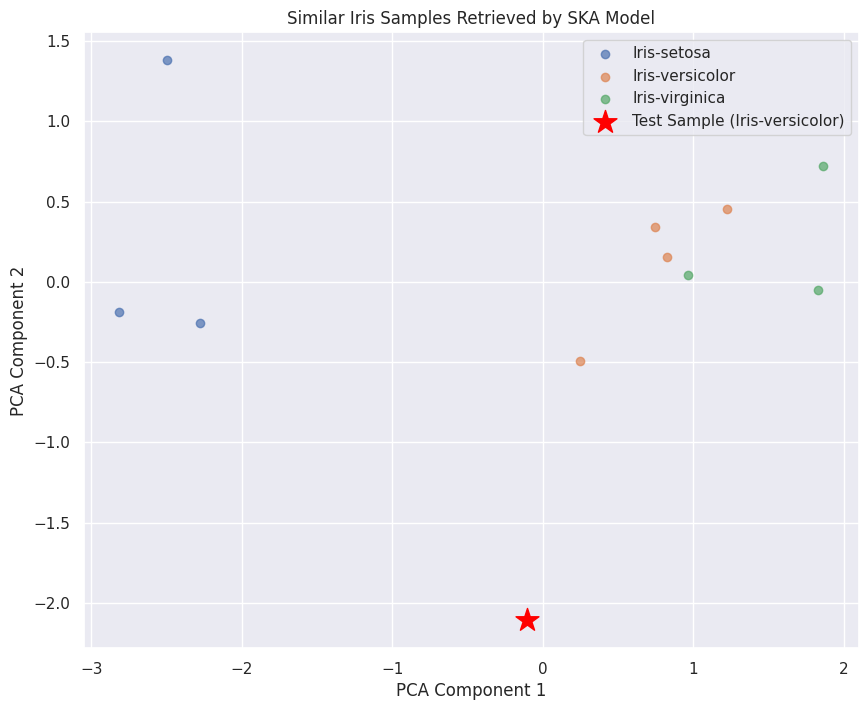

In [3]:
# Testing the SKA model
print("\nTesting the retrieval system...")

# Sample index
test_index = 3  # Valid index in the dataset


# Calling the retrieval function
top_indices, top_similarities = retrieve_similar_iris_samples(
    ska_model,
    test_index,
    X_test_tensor,  # Can use either test or train tensors
    y_test_tensor,
    num_similar=10
)

# Visualize the results
visualize_similar_iris_samples(
    ska_model,
    test_index,
    top_indices,
    top_similarities,
    X_test_tensor,  # Can use either test or train tensors
    y_test_tensor
)

## TRADITIONAL ALGORITHM

In [9]:
# Import Libraries
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting Numpy arrays to Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class TraditionalModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(num_features, 24),
            nn.ReLU(),
            nn.Linear(24, 18),
            nn.ReLU(),
            nn.Linear(18, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

    def forward(self, features):
        return self.network(features)

# Creating model instance
traditional_model = TraditionalModel(X_train_tensor.shape[1])

# Define loss function
loss_function = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-class classification

# Training parameters
learning_rate = 0.1
epochs = 300

# Define optimizer
optimizer = torch.optim.SGD(traditional_model.parameters(), lr=learning_rate)

# Lists to record metrics
traditional_epoch_list = []
traditional_accuracy_list = []

for epoch in range(epochs):
    # Forward pass
    outputs = traditional_model(X_train_tensor)

    # Calculate loss
    loss = loss_function(outputs, y_train_tensor)

    # Clear gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    # Record metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_outputs = traditional_model(X_test_tensor)
            _, predicted = torch.max(test_outputs, 1)
            acc = (predicted == y_test_tensor).float().mean().item()
        traditional_epoch_list.append(epoch + 1)
        traditional_accuracy_list.append(acc)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/300], Loss: 1.1026
Epoch [20/300], Loss: 1.0944
Epoch [30/300], Loss: 1.0861
Epoch [40/300], Loss: 1.0760
Epoch [50/300], Loss: 1.0603
Epoch [60/300], Loss: 1.0305
Epoch [70/300], Loss: 0.9730
Epoch [80/300], Loss: 0.8649
Epoch [90/300], Loss: 0.6992
Epoch [100/300], Loss: 0.5574
Epoch [110/300], Loss: 0.4711
Epoch [120/300], Loss: 0.4128
Epoch [130/300], Loss: 0.3668
Epoch [140/300], Loss: 0.3271
Epoch [150/300], Loss: 0.2920
Epoch [160/300], Loss: 0.2605
Epoch [170/300], Loss: 0.2329
Epoch [180/300], Loss: 0.2085
Epoch [190/300], Loss: 0.1856
Epoch [200/300], Loss: 0.1643
Epoch [210/300], Loss: 0.1447
Epoch [220/300], Loss: 0.1272
Epoch [230/300], Loss: 0.1121
Epoch [240/300], Loss: 0.0994
Epoch [250/300], Loss: 0.0894
Epoch [260/300], Loss: 0.0815
Epoch [270/300], Loss: 0.0752
Epoch [280/300], Loss: 0.0703
Epoch [290/300], Loss: 0.0663
Epoch [300/300], Loss: 0.0631


## Testing Traditional Model

Test Accuracy: 93.33%


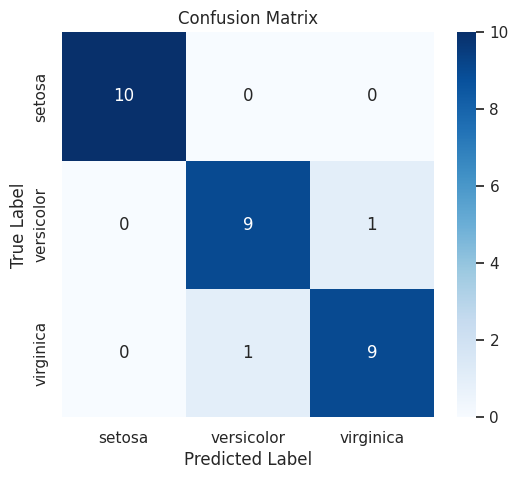

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model performance
with torch.no_grad():
    test_outputs = traditional_model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).float().mean().item()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Both Combined Analysis

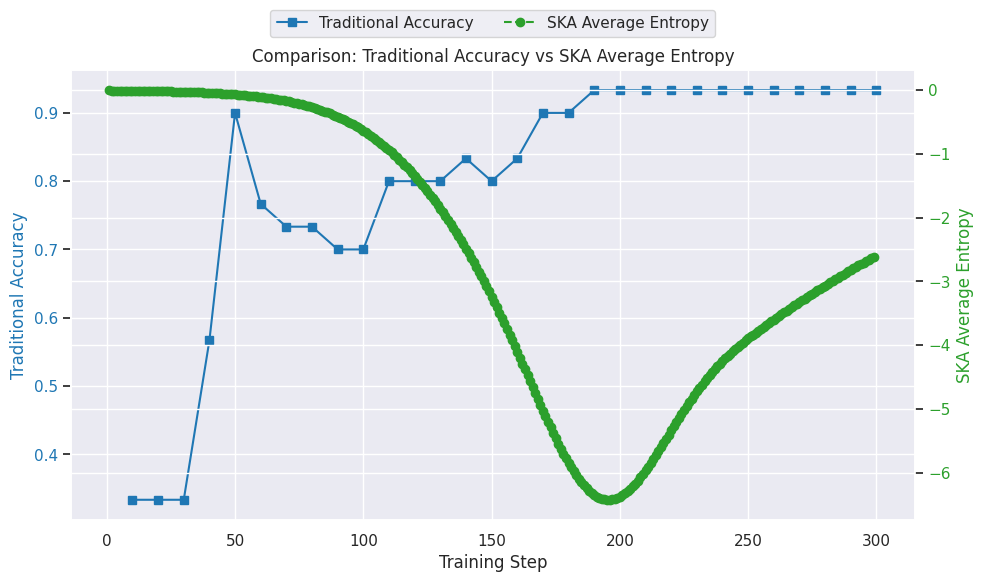

In [11]:
# Compute average entropy per SKA step across layers.

# Convert entropy_history (list of lists) to a NumPy array.
entropy_data = np.array(ska_model.entropy_history)  # Shape: (num_layers, num_steps)
avg_entropy = np.mean(entropy_data, axis=0)           # Average over layers
ska_steps = np.arange(1, len(avg_entropy) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Traditional Method Accuracy (x-axis: epochs)
color1 = 'tab:blue'
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Traditional Accuracy', color=color1)
ax1.plot(traditional_epoch_list, traditional_accuracy_list, marker='s', linestyle='-', color=color1, label='Traditional Accuracy')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis for SKA Average Entropy (x-axis: SKA steps)
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('SKA Average Entropy', color=color2)
ax2.plot(ska_steps, avg_entropy, marker='o', linestyle='--', color=color2, label='SKA Average Entropy')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.title("Comparison: Traditional Accuracy vs SKA Average Entropy")
plt.tight_layout()
plt.show()